### What we will learn

- We will build custom model for classfication
- We will show how to do Hypertuning with Keras Tuner - we will show how to scale Hypertuning with Vertex AI Visier 
- We will show how to use Vertex AI Experiments

In [166]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env', verbose=True)

True

In [167]:
import os

BIGQUERY_PROJECT_ID = os.environ.get('BIGQUERY_PROJECT_ID')
BIGQUERY_DATASET = os.environ.get('BIGQUERY_DATASET')
BIGQUERY_DATASET_REGION = os.environ.get('BIGQUERY_DATASET_REGION')
BIGQUERY_TABLE = os.environ.get('BIGQUERY_TABLE')

VERTEXAI_PROJECT_ID = os.environ.get('VERTEXAI_PROJECT_ID')
VERTEXAI_REGION = os.environ.get('VERTEXAI_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BUCKET_URI = os.environ.get('BUCKET_URI')
BUCKET_REGION = os.environ.get('BUCKET_REGION')

PREFIX = os.environ.get('PREFIX')

print("BIGQUERY_PROJECT_ID: ",BIGQUERY_PROJECT_ID)
print("BIGQUERY_DATASET: ",BIGQUERY_DATASET)
print("BIGQUERY_DATASET_REGION: ",BIGQUERY_DATASET_REGION)
print("BIGQUERY_TABLE: ",BIGQUERY_TABLE)

print("VERTEXAI_PROJECT_ID: ",VERTEXAI_PROJECT_ID)
print("VERTEXAI_REGION: ",VERTEXAI_REGION)

print("BUCKET_NAME: ",BUCKET_NAME)
print("BUCKET_URI: ",BUCKET_NAME)
print("BUCKET_REGION: ",VERTEXAI_REGION)

PIPELINE_ROOT = 'gs://{}/pipeline_root'.format(BUCKET_NAME)

BIGQUERY_PROJECT_ID:  datafusionsbox
BIGQUERY_DATASET:  dataset4ccc
BIGQUERY_DATASET_REGION:  us
BIGQUERY_TABLE:  df_for_model_ccc_with_weights
VERTEXAI_PROJECT_ID:  datafusionsbox
VERTEXAI_REGION:  us-central1
BUCKET_NAME:  gcp-demo-ccc-vertexai
BUCKET_URI:  gcp-demo-ccc-vertexai
BUCKET_REGION:  us-central1


In [168]:
gcs_output_dataset=f"{PIPELINE_ROOT}/staging/{PREFIX}.csv"
gcs_output_training_dataset=f"{PIPELINE_ROOT}/staging/{PREFIX}_training.csv"
gcs_output_validation_dataset=f"{PIPELINE_ROOT}/staging/{PREFIX}_validation.csv"
gcs_output_testing_dataset=f"{PIPELINE_ROOT}/staging/{PREFIX}_testing.csv"

In [172]:
from google.cloud import bigquery
import google.auth
    
##authenticate 
auth_credentials, auth_project = google.auth.default()
print("Project: "+auth_project)
client = bigquery.Client(project=BIGQUERY_PROJECT_ID, credentials = auth_credentials)
    
    
query = f"SELECT * FROM {BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"
print(query)
    
## fetch query results as dataframe
dataframe = client.query(query).to_dataframe()
##print(dataframe.head()) 
    
## export resultset into csv file om GCS
dataframe.to_csv(gcs_output_dataset)

Project: datafusionsbox
SELECT * FROM datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights


In [173]:
import pandas as pd
from sklearn.model_selection import train_test_split
    
dataset = pd.read_csv(gcs_output_dataset, index_col=0)

In [174]:
_excluded_columns = ["synerise_client_id", "weight"]  ####### uwaga na data leakage !!!! Weight ===== target
_target_column="y_if_trans"
_weight_column="weight"

In [175]:
## drop columns that are not needed
ndataset = dataset.drop(_excluded_columns, axis =1) 
ndataset.head()

,y_if_trans,www_visits_month_freq_1,www_visits_month_freq_2,www_visits_month_freq_3,www_pages_visited_month_1,www_pages_visited_month_2,www_pages_visited_month_3,www_time_onsite_avg_month_1,www_time_onsite_avg_month_2,www_time_onsite_avg_month_3,...,app_add_to_wishlist_month_freq_1,app_add_to_wishlist_month_freq_2,app_add_to_wishlist_month_freq_3,app_search_freq_month_freq_1,app_search_freq_month_freq_2,app_search_freq_month_freq_3,crm_club_level_id,crm_store_purchase_month_freq_1,crm_store_purchase_month_freq_2,crm_store_purchase_month_freq_3
0,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0.0,0.0,0.0,...,6,0,0,6,0,0,3,0,0,0
4,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,2,0,0,1


In [176]:
X = ndataset.loc[:, ndataset.columns != _target_column]
Y = ndataset.loc[:,ndataset.columns == _target_column]

In [177]:
X.head()

,www_visits_month_freq_1,www_visits_month_freq_2,www_visits_month_freq_3,www_pages_visited_month_1,www_pages_visited_month_2,www_pages_visited_month_3,www_time_onsite_avg_month_1,www_time_onsite_avg_month_2,www_time_onsite_avg_month_3,www_trans_month_freq_1,...,app_add_to_wishlist_month_freq_1,app_add_to_wishlist_month_freq_2,app_add_to_wishlist_month_freq_3,app_search_freq_month_freq_1,app_search_freq_month_freq_2,app_search_freq_month_freq_3,crm_club_level_id,crm_store_purchase_month_freq_1,crm_store_purchase_month_freq_2,crm_store_purchase_month_freq_3
0,0,0,0,0,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0.0,0.0,0.0,0,...,6,0,0,6,0,0,3,0,0,0
4,0,0,0,0,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,2,0,0,1


In [178]:
Y.head()

,y_if_trans
0,0
1,0
2,0
3,0
4,0


In [179]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=101)
    
training_dataset = pd.concat([X_train,Y_train], axis = 1)
validation_dataset = pd.concat([X_val,Y_val], axis = 1)
test_dataset = pd.concat([X_test,Y_test], axis = 1)

training_dataset.to_csv(gcs_output_training_dataset, index = False)
validation_dataset.to_csv(gcs_output_validation_dataset,index = False)
test_dataset.to_csv(gcs_output_testing_dataset,index = False)

In [21]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: keras-tuner
    Found existing installation: keras-tuner 1.0.1
    Uninstalling keras-tuner-1.0.1:
      Successfully uninstalled keras-tuner-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx 0.26.3 requires absl-py<0.11,>=0.9, but you have absl-py 1.3.0 which is incompatible.
tfx 0.26.3 requires attrs<21,>=19.3.0, but you have attrs 21.2.0 which is incompatible.
tfx 0.26.3 requires click<8,>=7, but you have click 8.0.1 which is incompatible.
tfx 0.26.3 requires docker<5,>=4.1, but you have docker 6.0.1 which is incompatible.
tfx 0.26.3 requires keras-tuner<1.0.2,>=1, but you have keras-tuner 1.2.1 which is incompatible.
tfx 0.26.3 requires kubernetes<12,>=10.0.1, but you have kubernetes 18.20.0 which is incompatible.
tfx 0.26.3 requires pyarrow<0.18

In [180]:
import tensorflow as tf
    
_METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    
## function to build model
def build_model(hptune):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=128, activation = "relu"))
        model.add(
           tf.keras.layers.Dense(
              # Define the hyperparameter
              units=hptune.Int("units", min_value=32, max_value=96, step=32),
              activation="relu" ##hptune.Choice("activation",["relu","tanh"]),
                )
        )
        if hptune.Boolean("dropout"):
           model.add(tf.keras.layers.Dropout(rate=0.25))
    
        model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
        learning_rate = 2e-4 ##hptune.Float("lr",min_value = 1e-4, max_value=1e-2, sampling="log")

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(), 
            metrics=_METRICS,
        )
        return model
    

In [181]:
training_dataset = pd.read_csv(gcs_output_training_dataset)
validation_dataset = pd.read_csv(gcs_output_validation_dataset)
test_dataset = pd.read_csv(gcs_output_testing_dataset)

In [182]:
training_dataset.head()

,www_visits_month_freq_1,www_visits_month_freq_2,www_visits_month_freq_3,www_pages_visited_month_1,www_pages_visited_month_2,www_pages_visited_month_3,www_time_onsite_avg_month_1,www_time_onsite_avg_month_2,www_time_onsite_avg_month_3,www_trans_month_freq_1,...,app_add_to_wishlist_month_freq_2,app_add_to_wishlist_month_freq_3,app_search_freq_month_freq_1,app_search_freq_month_freq_2,app_search_freq_month_freq_3,crm_club_level_id,crm_store_purchase_month_freq_1,crm_store_purchase_month_freq_2,crm_store_purchase_month_freq_3,y_if_trans
0,0,2,2,0,5,3,0.0,105.0,10.0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,1,5,0,116.0,667.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,4,0,0,1327.0,0.0,0.0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0


In [187]:
feature_columns = [column for column in training_dataset.columns if _target_column != column]
target_columns = [_target_column]

x_train = training_dataset[feature_columns]
y_train = training_dataset[target_columns]

In [188]:
x_train.head()

,www_visits_month_freq_1,www_visits_month_freq_2,www_visits_month_freq_3,www_pages_visited_month_1,www_pages_visited_month_2,www_pages_visited_month_3,www_time_onsite_avg_month_1,www_time_onsite_avg_month_2,www_time_onsite_avg_month_3,www_trans_month_freq_1,...,app_add_to_wishlist_month_freq_1,app_add_to_wishlist_month_freq_2,app_add_to_wishlist_month_freq_3,app_search_freq_month_freq_1,app_search_freq_month_freq_2,app_search_freq_month_freq_3,crm_club_level_id,crm_store_purchase_month_freq_1,crm_store_purchase_month_freq_2,crm_store_purchase_month_freq_3
0,0,2,2,0,5,3,0.0,105.0,10.0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,1,5,0,116.0,667.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,4,0,0,1327.0,0.0,0.0,0,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [189]:
x_train = training_dataset[feature_columns]
y_train = training_dataset[target_columns]

x_val = validation_dataset[feature_columns]
y_val = validation_dataset[target_columns]

x_test = test_dataset[feature_columns]
y_test = test_dataset[target_columns]

In [190]:
x_train.shape, y_train.shape

((832796, 67), (832796, 1))

In [ ]:
### Hyperparameter tuning

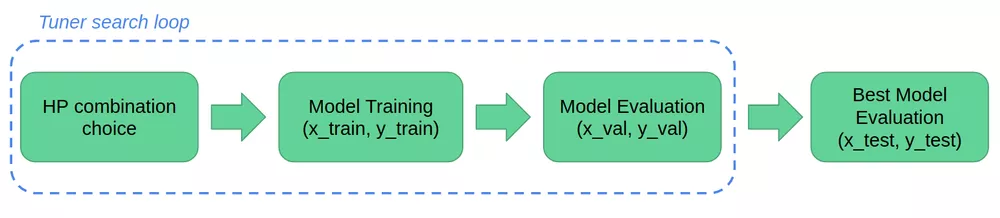

Hyperband is an optimized version of random search which uses early-stopping to speed up the hyperparameter tuning process. The main idea is to fit a large number of models for a small number of epochs and to only continue training for the models achieving the highest accuracy on the validation set. The max_epochs variable is the max number of epochs that a model can be trained for.

In [195]:
import keras_tuner

trials_dir=f"{PREFIX}_trials_v1"

##Create a Keras Hyperband Hyperparameter tuner with an accuracy objective
tuner =  keras_tuner.Hyperband(
       hypermodel=build_model,
       objective=keras_tuner.Objective("auc", direction="max"),
       max_epochs=10,
       factor=3,
       hyperband_iterations=1,
       seed=None,
       hyperparameters=None,
       tune_new_entries=True,
       allow_new_entries=True,
       directory=trials_dir
)

In [ ]:
tuner.search_space_summary()

In [197]:
weight_for_0 = 0.5 ##(1 / neg) * (total / 2.0)
weight_for_1 = 20 ##(1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 20.00


In [198]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
output = tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val) , callbacks=[stop_early], class_weight=class_weights) ## you can also use validation_split=0.2 if you do not have validation data

Trial 26 Complete [00h 07m 01s]
auc: 0.7666996717453003

Best auc So Far: 0.7666996717453003
Total elapsed time: 01h 46m 48s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
32                |96                |units
tanh              |relu              |activation
False             |False             |dropout
0.00012417        |0.00010979        |lr
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/10
26025/26025 [==============================] - 87s 3ms/step - loss: 0.6018 - tp: 16739.0000 - fp: 345460.0000 - tn: 670648.0000 - fn: 8149.0000 - accuracy: 0.6603 - precision: 0.0462 - recall: 0.6726 - auc: 0.7227 - prc: 0.0632 - val_loss: 0.5653 - val_tp: 3401.0000 - val_fp: 67150.0000 - val_tn: 136025.0000 - val_fn: 1624.0000 - val_accuracy: 0.6697 - val_precision: 0.0482 - val_recall: 

KeyboardInterrupt: 

In [ ]:
# Get the optimal hyperparameters for the model as determined from the search
best_hyperparameters=tuner.get_best_hyperparameters()[0]
hypermodel = tuner.hypermodel.build(best_hyperparameters)
history = hypermodel.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
26025/26025 [==============================] - 85s 3ms/step - loss: 0.1717 - tp: 6706.0000 - fp: 126565.0000 - tn: 1087808.0000 - fn: 22917.0000 - accuracy: 0.8798 - precision: 0.0503 - recall: 0.2264 - auc: 0.5646 - prc: 0.0393 - val_loss: 0.1628 - val_tp: 342.0000 - val_fp: 3688.0000 - val_tn: 199487.0000 - val_fn: 4683.0000 - val_accuracy: 0.9598 - val_precision: 0.0849 - val_recall: 0.0681 - val_auc: 0.6537 - val_prc: 0.0484
Epoch 2/10
26025/26025 [==============================] - 83s 3ms/step - loss: 0.1274 - tp: 311.0000 - fp: 2280.0000 - tn: 810653.0000 - fn: 19552.0000 - accuracy: 0.9738 - precision: 0.1200 - recall: 0.0157 - auc: 0.6625 - prc: 0.0555 - val_loss: 0.1381 - val_tp: 283.0000 - val_fp: 3001.0000 - val_tn: 200174.0000 - val_fn: 4742.0000 - val_accuracy: 0.9628 - val_precision: 0.0862 - val_recall: 0.0563 - val_auc: 0.7100 - val_prc: 0.0541
Epoch 3/10
26025/26025 [==============================] - 81s 3ms/step - loss: 0.1165 - tp: 198.0000 - fp: 1406.0000

In [27]:
print(history.history.keys())

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc'])


In [28]:
import matplotlib.pyplot as plt

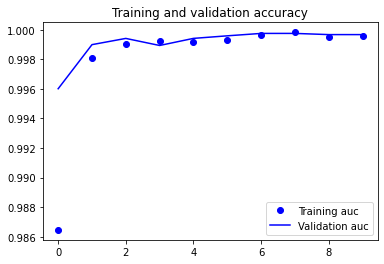

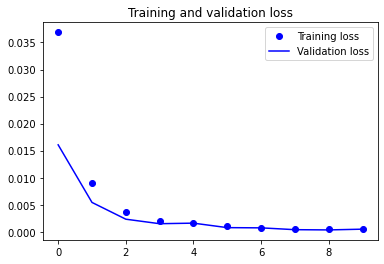

In [29]:
plt.plot(history.history['auc'], 'bo', label='Training auc')
plt.plot(history.history['val_auc'], 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(history.history['loss'], 'bo', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
results = hypermodel.evaluate(X_test, Y_test)

8133/8133 [==============================] - 19s 2ms/step - loss: 4.8539e-04 - tp: 6170.0000 - fp: 0.0000e+00 - tn: 254053.0000 - fn: 26.0000 - accuracy: 0.9999 - precision: 1.0000 - recall: 0.9958 - auc: 0.9997 - prc: 0.9994


In [41]:
results[0]

0.0004853927530348301

In [39]:
model_path=f"{PIPELINE_ROOT}/experimentation/{PREFIX}/"
hypermodel.save(model_path)

2023-02-20 12:05:10.678189: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://gcp-demo-ccc-vertexai/pipeline_root/experimentation/ccc/assets


INFO:tensorflow:Assets written to: gs://gcp-demo-ccc-vertexai/pipeline_root/experimentation/ccc/assets


### Vertex AI Experiments

In [44]:
VERETXAI_EXPERIMENT_NAME=f"{PREFIX}-promo"
VERETXAI_EXPERIMENT_NAME

'ccc-promo'

In [88]:
from google.cloud import aiplatform
from datetime import datetime

## register hyperparameters and metrics as Vertex AI experiment run
aiplatform.init(
       project=VERTEXAI_PROJECT_ID,
       location=VERTEXAI_REGION,
       experiment=VERETXAI_EXPERIMENT_NAME
)
    
run_id = f"run-{datetime.now().strftime('%Y%m%d%H%M%S')}"
run = aiplatform.start_run(run_id)
    
training_params = {
        'training_dataset': gcs_output_training_dataset,
        'validation_dataset': gcs_output_validation_dataset,
        'test_dataset': gcs_output_testing_dataset,
        'model_type': 'nn',
        'model_path': model_path,
        'trainedby': PREFIX, 
        'hp_units': best_hyperparameters.get('units'),
        'hp_activation': best_hyperparameters.get('activation'),
        'hp_dropout': best_hyperparameters.get('dropout'),
        'hp_lr': best_hyperparameters.get('lr'),
}
    
training_metrics = {
        'model_loss': results[0],
        'model_accuracy': results[5],
        'model_precision': results[6],
        'model_recall': results[7],
        'model_auc': results[8],
        'model_prc': results[9],
        'model_tp': results[1],
        'model_fp': results[2],
        'model_tn': results[3],
        'model_fn': results[4]
    }
    
run.log_params(training_params)
run.log_metrics(training_metrics)

##aiplatform.log_model(hypermodel)

classification_metrics = run.log_classification_metrics(
    display_name='classification metrics',
    labels=['Positive', 'Negative'],
    matrix=[[results[1], results[2]], [results[4], results[3]]],
    fpr=[],
    tpr=[],
    threshold=[],
)

run.end_run() ## otherwise

Associating projects/339239659794/locations/us-central1/metadataStores/default/contexts/ccc-promo-run-20230220145432 to Experiment: ccc-promo


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/339239659794/locations/us-central1/metadataStores/default/contexts/ccc-promo-run-20230220145432 to Experiment: ccc-promo


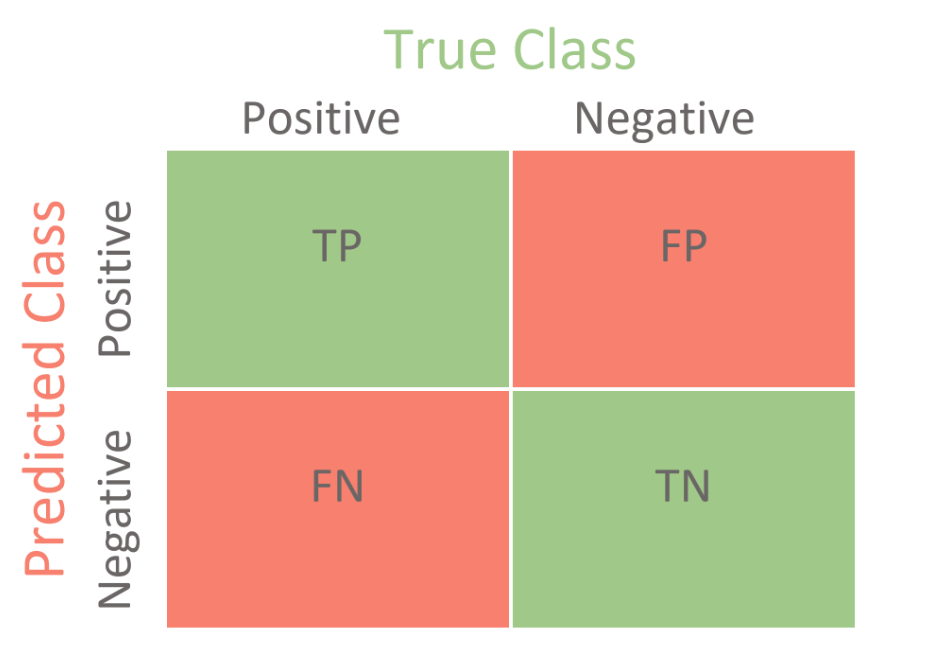

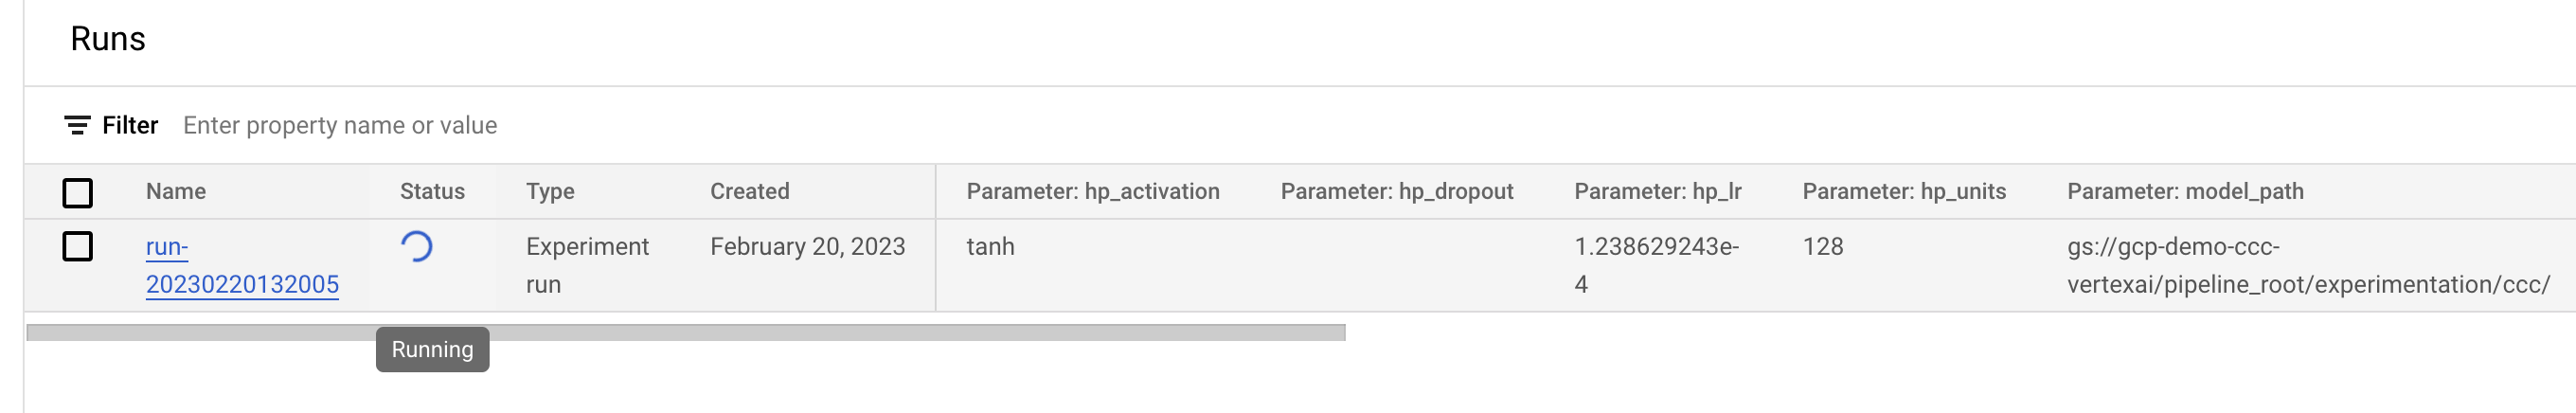

### Upload model to Vertex AI Model Registry

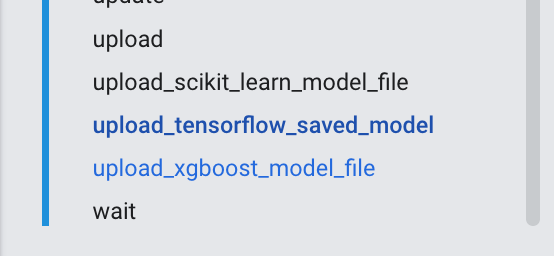

In [84]:
MODEL_NAME = f"{PREFIX}_model_exc_3a"
vertexai_model = aiplatform.Model.upload_tensorflow_saved_model(
         display_name = MODEL_NAME,
         saved_model_dir = model_path,
         labels = [],
         is_default_version = True
)

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/339239659794/locations/us-central1/models/2526187338443259904/operations/568393429332000768


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/339239659794/locations/us-central1/models/2526187338443259904/operations/568393429332000768


Model created. Resource name: projects/339239659794/locations/us-central1/models/2526187338443259904@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/339239659794/locations/us-central1/models/2526187338443259904@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/339239659794/locations/us-central1/models/2526187338443259904@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/339239659794/locations/us-central1/models/2526187338443259904@1')


In [85]:
ENDPOINT_NAME = f"{MODEL_NAME}_endpoint"
champion_endpoint = aiplatform.Endpoint.create(
          display_name = ENDPOINT_NAME,
          labels = []   
)

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/339239659794/locations/us-central1/endpoints/929698653935763456/operations/2333804483261235200


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/339239659794/locations/us-central1/endpoints/929698653935763456/operations/2333804483261235200


Endpoint created. Resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/339239659794/locations/us-central1/endpoints/929698653935763456')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/339239659794/locations/us-central1/endpoints/929698653935763456')


In [86]:
serving_machine_type = "n1-standard-4"
serving_min_replica  = 1
serving_max_replica  = 1

In [87]:
#### Deploy model to endpoint
champion_endpoint.deploy(
       model = vertexai_model,
       traffic_percentage = 100,
       machine_type=serving_machine_type,
       min_replica_count=serving_min_replica,
       max_replica_count=serving_max_replica
)

Deploying Model projects/339239659794/locations/us-central1/models/2526187338443259904 to Endpoint : projects/339239659794/locations/us-central1/endpoints/929698653935763456


INFO:google.cloud.aiplatform.models:Deploying Model projects/339239659794/locations/us-central1/models/2526187338443259904 to Endpoint : projects/339239659794/locations/us-central1/endpoints/929698653935763456


Deploy Endpoint model backing LRO: projects/339239659794/locations/us-central1/endpoints/929698653935763456/operations/4741541434044186624


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/339239659794/locations/us-central1/endpoints/929698653935763456/operations/4741541434044186624


Endpoint model deployed. Resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456


In [ ]:
import numpy as np
import json
inputs = np.arange(100)

_instances = list(map(lambda x: [int(x)], inputs))

In [123]:
len(feature_columns)

68

In [148]:
import random

num_instances = 5

def generate_random_instances(num_instances: int): 
  instances = []
  for i in range(0,num_instances):
    instance = []
    for i in range(0, len(feature_columns)):
        n = random.randint(0,200)
        instance.append(n)
    print(instance)
    instances.append(instance)
  return instances      


In [149]:
_instances= generate_random_instances(5)

[193, 51, 114, 140, 136, 132, 125, 63, 179, 191, 85, 0, 181, 163, 17, 20, 115, 16, 200, 15, 33, 81, 149, 156, 20, 155, 35, 163, 31, 11, 0, 99, 40, 119, 160, 104, 147, 59, 113, 12, 94, 189, 77, 186, 95, 110, 147, 26, 112, 40, 101, 34, 179, 2, 118, 174, 106, 9, 52, 110, 39, 162, 153, 178, 67, 176, 172, 162]
[178, 200, 10, 118, 140, 139, 168, 136, 149, 176, 130, 125, 32, 193, 50, 28, 8, 169, 192, 45, 77, 49, 190, 74, 75, 12, 171, 16, 21, 8, 199, 44, 41, 119, 124, 48, 192, 106, 103, 177, 26, 48, 72, 72, 16, 188, 119, 91, 0, 133, 104, 152, 174, 172, 157, 160, 144, 116, 108, 77, 128, 153, 75, 97, 187, 163, 103, 128]
[7, 193, 149, 46, 10, 8, 148, 117, 67, 75, 40, 104, 81, 134, 33, 110, 86, 85, 20, 10, 96, 135, 17, 54, 200, 144, 13, 171, 133, 145, 3, 61, 53, 38, 37, 26, 165, 190, 85, 114, 97, 139, 154, 136, 120, 124, 56, 79, 44, 77, 10, 139, 48, 101, 81, 55, 185, 62, 63, 104, 91, 147, 116, 19, 70, 112, 198, 187]
[21, 114, 91, 13, 161, 165, 54, 124, 14, 131, 138, 100, 45, 124, 129, 129, 116, 21

### Predict using Vertex AI SDK

In [154]:
result = champion_endpoint.predict(instances=_instances)   ### check order of responses
result

Prediction(predictions=[[1.44915063e-07], [1.90312036e-07], [1.90312036e-07], [1.66844274e-07], [1.89458746e-07]], deployed_model_id='7194003425468612608', model_version_id='1', model_resource_name='projects/339239659794/locations/us-central1/models/2526187338443259904', explanations=None)

### Predict using REST API

In [155]:
content = "{ \"instances\":"+str(_instances)+"}"
content

'{ "instances":[[193, 51, 114, 140, 136, 132, 125, 63, 179, 191, 85, 0, 181, 163, 17, 20, 115, 16, 200, 15, 33, 81, 149, 156, 20, 155, 35, 163, 31, 11, 0, 99, 40, 119, 160, 104, 147, 59, 113, 12, 94, 189, 77, 186, 95, 110, 147, 26, 112, 40, 101, 34, 179, 2, 118, 174, 106, 9, 52, 110, 39, 162, 153, 178, 67, 176, 172, 162], [178, 200, 10, 118, 140, 139, 168, 136, 149, 176, 130, 125, 32, 193, 50, 28, 8, 169, 192, 45, 77, 49, 190, 74, 75, 12, 171, 16, 21, 8, 199, 44, 41, 119, 124, 48, 192, 106, 103, 177, 26, 48, 72, 72, 16, 188, 119, 91, 0, 133, 104, 152, 174, 172, 157, 160, 144, 116, 108, 77, 128, 153, 75, 97, 187, 163, 103, 128], [7, 193, 149, 46, 10, 8, 148, 117, 67, 75, 40, 104, 81, 134, 33, 110, 86, 85, 20, 10, 96, 135, 17, 54, 200, 144, 13, 171, 133, 145, 3, 61, 53, 38, 37, 26, 165, 190, 85, 114, 97, 139, 154, 136, 120, 124, 56, 79, 44, 77, 10, 139, 48, 101, 81, 55, 185, 62, 63, 104, 91, 147, 116, 19, 70, 112, 198, 187], [21, 114, 91, 13, 161, 165, 54, 124, 14, 131, 138, 100, 45, 124

In [156]:
INPUT_FILE_LONG="instances.json"
f = open(INPUT_FILE_LONG, "w")
f.write(content)
f.close()

In [157]:
ENDPOINT_ID = champion_endpoint.name
ENDPOINT_ID

'929698653935763456'

In [158]:
endpoint_url=f"https://{VERTEXAI_REGION}-aiplatform.googleapis.com/v1/projects/{VERTEXAI_PROJECT_ID}/locations/{VERTEXAI_REGION}/endpoints/{ENDPOINT_ID}"
endpoint_url

'https://us-central1-aiplatform.googleapis.com/v1/projects/datafusionsbox/locations/us-central1/endpoints/929698653935763456'

In [159]:
! curl \
-X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
-d @instances.json \
https://{VERTEXAI_REGION}-aiplatform.googleapis.com/v1/projects/{VERTEXAI_PROJECT_ID}/locations/{VERTEXAI_REGION}/endpoints/{ENDPOINT_ID}:predict

{
  "predictions": [
    [
      1.44915063e-07
    ],
    [
      1.90312036e-07
    ],
    [
      1.90312036e-07
    ],
    [
      1.66844274e-07
    ],
    [
      1.89458746e-07
    ]
  ],
  "deployedModelId": "7194003425468612608",
  "model": "projects/339239659794/locations/us-central1/models/2526187338443259904",
  "modelDisplayName": "ccc_model_exc_3a",
  "modelVersionId": "1"
}


#### Clean

In [161]:
champion_endpoint.undeploy_all()

Undeploying Endpoint model: projects/339239659794/locations/us-central1/endpoints/929698653935763456


INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/339239659794/locations/us-central1/endpoints/929698653935763456


Undeploy Endpoint model backing LRO: projects/339239659794/locations/us-central1/endpoints/929698653935763456/operations/8922570738104270848


INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/339239659794/locations/us-central1/endpoints/929698653935763456/operations/8922570738104270848


Endpoint model undeployed. Resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456


INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456


resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456

In [162]:
champion_endpoint.delete()

Deleting Endpoint : projects/339239659794/locations/us-central1/endpoints/929698653935763456


INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/339239659794/locations/us-central1/endpoints/929698653935763456


Delete Endpoint  backing LRO: projects/339239659794/locations/us-central1/operations/4192102279504986112


INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/339239659794/locations/us-central1/operations/4192102279504986112


Endpoint deleted. . Resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456


INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/339239659794/locations/us-central1/endpoints/929698653935763456


In [163]:
vertexai_model.delete()

Deleting Model : projects/339239659794/locations/us-central1/models/2526187338443259904


INFO:google.cloud.aiplatform.base:Deleting Model : projects/339239659794/locations/us-central1/models/2526187338443259904


Delete Model  backing LRO: projects/339239659794/locations/us-central1/operations/3153459615442665472


INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/339239659794/locations/us-central1/operations/3153459615442665472


Model deleted. . Resource name: projects/339239659794/locations/us-central1/models/2526187338443259904


INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/339239659794/locations/us-central1/models/2526187338443259904
